In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve
from scipy.spatial.distance import pdist, squareform

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
pos_flat = np.loadtxt('ex18_data.txt')
positions = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)

In [3]:
class PairDistances: # Interatomic Distance Distribution
    def __init__(self, color='C1'):
        self.xwidth = 0.5
        self.color = color
        self.bin_edges = np.arange(0,7.01,self.xwidth)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) /2
    
    def descriptor(self, pos):
        dists = pdist(pos)
        hist, _ = np.histogram(dists, bins=self.bin_edges)
        return hist
    
    def draw(self, pos, ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_title(self.__class__.__name__)


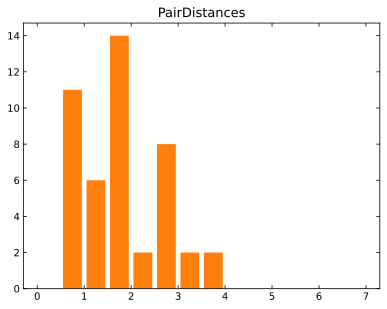

In [4]:
pd = PairDistances()
pd.draw(positions[0], plt.gca())

In [5]:
class CoordinationNumbers: # Coordination Number Profile
    def __init__(self, color='C2'):
        self.xwidth = 1
        self.color = color
        self.r_cut = 1.2
    
    def descriptor(self, pos):
        dists = squareform(pdist(pos))
        return np.sum(dists < self.r_cut, axis=1)
    
    def draw(self, pos, ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_title(self.__class__.__name__)


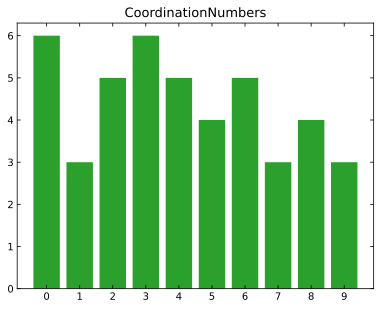

In [6]:
cn = CoordinationNumbers()
cn.draw(positions[0], plt.gca())

In [7]:
class ConnectivityGraphSpectrum: # Connectivity Graph Spectrum
    def __init__(self, color='C3'):
        self.xwidth = 1
        self.color = color
        self.r_cut = 1.2
    
    def descriptor(self, pos):
        connectivity_matrix = (squareform(pdist(pos)) < self.r_cut).astype(int)
        np.fill_diagonal(connectivity_matrix, 0)
        eigenvalues = np.linalg.eigvalsh(connectivity_matrix)
        return eigenvalues
    
    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_title(self.__class__.__name__)

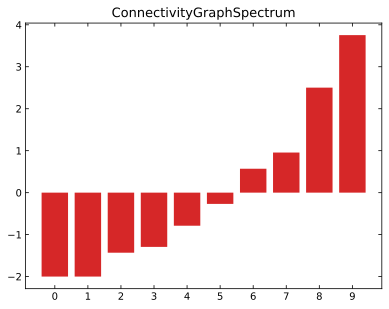

In [8]:
cgs = ConnectivityGraphSpectrum()
cgs.draw(positions[0], plt.gca())

In [9]:
class CoulombMatrixSpectrum:
    def __init__(self, color='C4'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self, pos):
        dists = squareform(pdist(pos))
        np.fill_diagonal(dists, 1)
        inv_dists = 1/dists
        np.fill_diagonal(inv_dists, 0)
        eigenvalues = np.linalg.eigvalsh(inv_dists)
        return eigenvalues

    def draw(self, pos, ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([-2,8])
        ax.set_title(self.__class__.__name__)

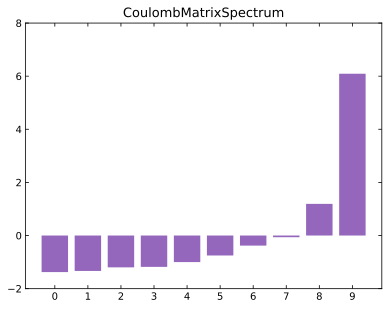

In [10]:
cms = CoulombMatrixSpectrum()
cms.draw(positions[0], plt.gca())

In [11]:
class DescriptorCollection:
    def __init__(self, eps0=5, sigma=2**(-1/6), x_range=[-4,4], y_range=[-4,4]):
        self.descriptors = [PairDistances(), CoordinationNumbers(), ConnectivityGraphSpectrum(), CoulombMatrixSpectrum()]
        self.N_descriptors = len(self.descriptors)
        self.eps0 = eps0
        self.sigma = sigma
        self.x_range = x_range
        self.y_range = y_range
    
    def potential(self, r):
        return 4 * self.eps0 * ((self.sigma / r)**12 - (self.sigma / r)**6)
    
    def total_energy(self, pos):
        dists = pdist(pos)
        return np.sum(self.potential(dists))
    
    def plot_2Dcluster(self, pos, ax):
        ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=self.x_range, ylim=self.y_range)
        ax.grid(alpha=0.5)
        ax.scatter(*pos.T, edgecolors='k')
        ax.set_title(fr'$E = {self.total_energy(pos):.3f}$')
    
    def plot_descriptors(self, pos, axs, idd=True, cnp=True, cgs=True, cms=True):
        try:
            N_axs = len(axs)
        except TypeError:
            N_axs = 1
        descriptor_list = [idd, cnp, cgs, cms]
        descriptors_to_be_used = [self.descriptors[i] for i in range(self.N_descriptors) if descriptor_list[i]]
        if N_axs == 1:
            descriptors_to_be_used[0].draw(pos, axs)
        else:
            for i in range(N_axs):
                descriptors_to_be_used[i].draw(pos, axs[i])

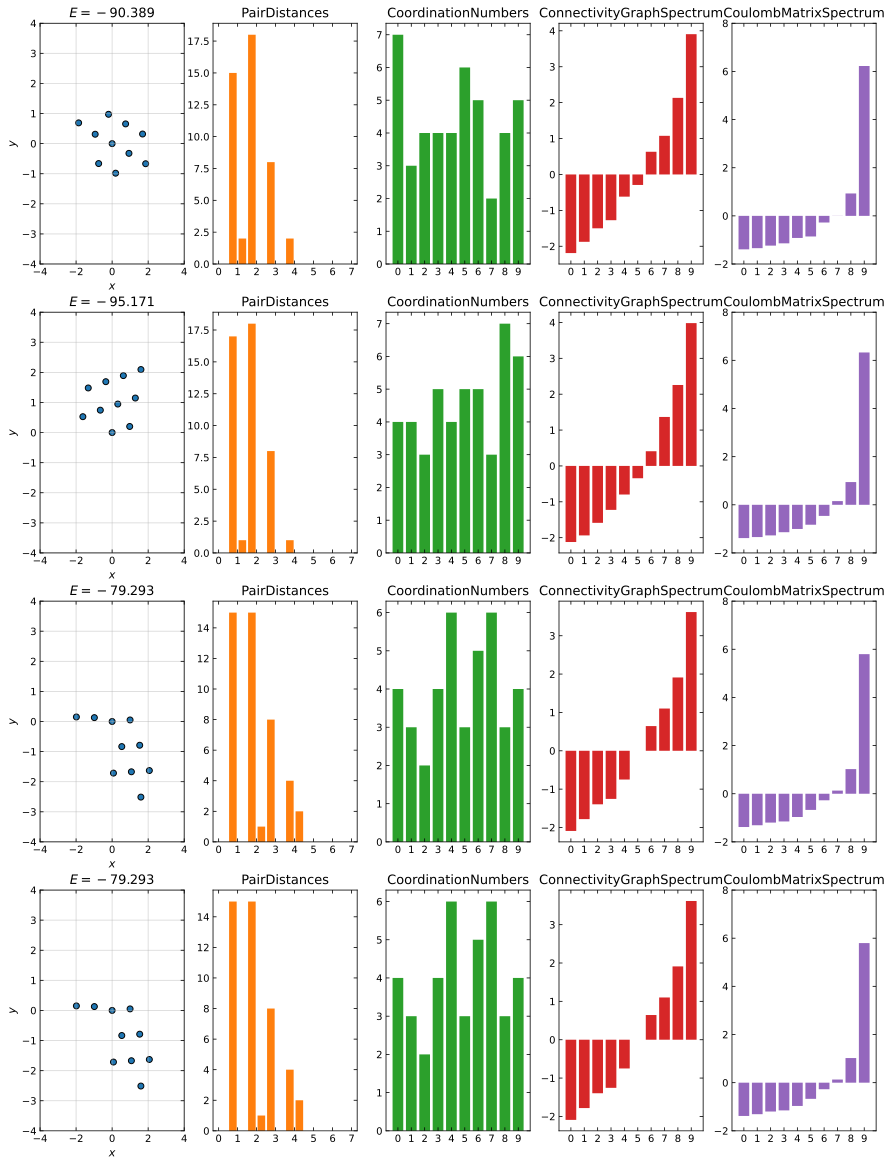

In [12]:
dc = DescriptorCollection()
fig, axs = plt.subplots(4, 5, figsize=(15, 20))
for ax in axs:
    i = np.random.randint(0, len(positions))
    dc.plot_2Dcluster(positions[i], ax[0])
    dc.plot_descriptors(positions[i], ax[1:])

fig.savefig('ex20_fig1.png')